# Quantum Mechanical and Molecular Dynamics Calculations

## Comparison with Experimental Measurements

Start by importing some modules:

In [1]:
import salty
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.rdmolfiles import MolToPDBFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import gains as genetic
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
from keras.models import load_model
from os.path import join
from numpy import array
from gains.salt_generator import _get_fitness as get_fitness
% matplotlib inline

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


defining a few helper functions:

In [2]:
def myround(x, base=1):
    return (float(base) * round(float(x)/float(base)))

def get_raad(guess, real):
    return np.average(np.abs((guess - real) / real)) * 100

def load_salty_models(model_ID, path=None):
    for i, name in enumerate(model_ID):
        if path:
            model = np.array([load_model(join(path,
                                              '{}_qspr.h5'.format(name)))])
            with open(join(path, '{}_desc.csv'.format(name)),
                      'rb') as csv_file:
                deslist = list([pd.read_csv(csv_file, encoding='latin1')])
            with open(join(path, '{}_summ.csv'.format(name)),
                      'rb') as csv_file:
                summary = pd.read_csv(csv_file, encoding='latin1')
        else:
            model = np.array([genetic.load_data("{}_qspr.h5".format(name),
                                                h5File=True)])
            deslist = list([genetic.load_data("{}_desc.csv".format(name))])
            summary = genetic.load_data("{}_summ.csv".format(name))
        parents = eval(summary.iloc[1][1])
        anions = eval(summary.iloc[2][1])
        if i > 0:
            parent_candidates = np.concatenate((parents, parent_candidates))
            anion_candidates = np.concatenate((anions, anion_candidates))
            models = np.concatenate((models, model))
            deslists = list([deslists, deslist])
        else:
            parent_candidates = parents
            anion_candidates = anions
            models = model
            deslists = deslist
    return parent_candidates, anion_candidates, models, deslists

as well as keys we'll use throughout the notebook:

In [3]:
name_dic = {"BAM.FOR": "n-butylammonium formate",
        "BMI.ACE": "1-butyl-3-methylimidazolium acetate",
        "BMI.TF2": "1-butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide",
        "EMI.ACE": "1-ethyl-3-methylimidazolium acetate",
        "EMI.ETS": "1-ethyl-3-methylimidazolium ethyl sulfate",
        "EMI.TF2": "1-ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide",
        "EPY.ETS": "1-ethylpyridinium ethyl sulfate",
        "EPY.TF2": "1-ethylpyridinium ethyl bis(trifluoromethylsulfonyl)imide",
        "HMI.CHL": "1-hexyl-3-methylimidazolium chloride",
        "HMI.TF2": "1-hexyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide",
        "HPY.TF2": "1-hexylpyridinium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F",
        "OMI.CHL": "1-octyl-3-methylimidazolium chloride",
        "OMI.TF2": "1-octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide",
        "PAM.FOR": "pentylammonium formate",
        "PPY.TF2": "1-pentylpyridinium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F"}
smiles_dic = {"BAM.FOR": "CCCC[NH3+].C(=O)[O-]",
        "BMI.ACE": "CCCCn1cc[n+](c1)C.CC(=O)[O-]",
        "BMI.TF2": "CCCCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F",
        "EMI.ACE": "CCn1cc[n+](c1)C.CC(=O)[O-]",
        "EMI.ETS": "CCn1cc[n+](c1)C.CCOS(=O)(=O)[O-]",
        "EMI.TF2": "CCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F",
        "EPY.ETS": "CC[n+]1ccccc1.CCOS(=O)(=O)[O-]",
        "EPY.TF2": "CC[n+]1ccccc1.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F",
        "HMI.CHL": "CCCCCCn1cc[n+](c1)C.[Cl-]",
        "HMI.TF2": "CCCCCCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F",
        "HPY.TF2": "CCCCCC[n+]1ccccc1.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F",
        "OMI.CHL": "CCCCCCCCn1cc[n+](c1)C.[Cl-]",
        "OMI.TF2": "CCCCCCCCn1cc[n+](c1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F",
        "PAM.FOR": "CCCCC[NH3+].C(=O)[O-]",
        "PPY.TF2": "CCCCC[n+]1ccccc1.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F"}

and loading our experimental data:

In [4]:
df = pd.read_csv("../data/density_heat_capacity_comparison_data.csv")
df#.head()

,Salt,Exp_Density,Exp_Density_Std,Density_Reference,Exp_Cpt,Exp_Cpt_Std,Cpt_Reference
0,BAM.FOR,928.00,25.00,"Greaves, T. L.; Weerawardena, A.; Fong, C.; Kr...",NaN,NaN,NaN
1,BMI.ACE,1052.60,6.00,"Safarov, J.; Geppert-Rybczynska, M.; Kul, I.; ...",381.0,23.0,"Safarov, J.; Geppert-Rybczynska, M.; Kul, I.; ..."
2,BMI.TF2,1436.80,2.90,"Hamidova, R.; Kul, I.; Safarov, J.; Shahverdiy...",531.0,54.0,"Gomez, E.; Calvar, N.; Dominguez, A.; Macedo, ..."
3,EMI.ACE,1099.30,2.00,"Freire, M. G.; Teles, A. R. R.; Rocha, M. A. A...",325.2,6.5,"Su, C.; Liu, X.; Zhu, C.; He, M. (2016) Fluid ..."
4,EMI.ETS,1236.02,0.44,"Matkowska, D.; Hofman, T. (2012) J. Mol. Liq. ...",378.0,26.0,"Zhang, Z.-H.; Tan, Z.-C.; Sun, L.-X.; Jia-Zhen..."
5,EMI.TF2,1519.11,0.70,"Jacquemin, J.; Husson, P.; Majer, V.; Gomes, M...",462.0,47.0,"Gomez, E.; Calvar, N.; Dominguez, A.; Macedo, ..."
6,EPY.ETS,1221.80,1.10,"Diogo, J. C. F.; Caetano, F. J. P.; Fareleira,...",389.0,39.0,"Crosthwaite, J. M.; Muldoon, M. J.; Dixon, J. ..."
7,EPY.TF2,1488.54,0.66,"Gonzalez, E. J.; Gonzalez, B.; Macedo, E. A. (...",491.0,50.0,"Calvar, N.; Gomez, E.; Macedo, E. A.; Domingue..."
8,HMI.CHL,1042.20,0.98,"Yan, X.-J.; Li, S.-N.; Zhai, Q.-G.; Jiang, Y.-...",NaN,NaN,NaN
9,HMI.TF2,1372.40,1.70,"Safarov, J.; Hamidova, R.; Zepik, S.; Schmidt,...",635.0,11.0,"Archer, D. G. (2006) National Insitute of Stan..."


load the MD data:

In [5]:
md_dens = []
md_cpt = []
md_dens_std = []
md_cpt_std = []
path = "../data/molecular_dynamics/known_salts/"
print("density\t cp\t name")
for key in smiles_dic:
    dens = np.genfromtxt("{}"\
                     "{}.298.comremoved.dens".format(path, key), delimiter=",")
    cpt = np.genfromtxt("{}"\
                     "{}.298.comremoved.Cp".format(path, key), delimiter=",")
    print("{:.1f}\t {:.1f}\t {}".format(np.mean(dens),np.mean(cpt),name_dic[key]))
    md_dens.append(np.mean(dens))
    md_cpt.append(np.mean(cpt))
    md_dens_std.append(np.std(dens))
    md_cpt_std.append(np.std(cpt))

density	 cp	 name
992.8	 259.9	 n-butylammonium formate
1011.0	 395.7	 1-butyl-3-methylimidazolium acetate
1417.7	 529.9	 1-butyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide
1061.5	 324.1	 1-ethyl-3-methylimidazolium acetate
1217.4	 389.2	 1-ethyl-3-methylimidazolium ethyl sulfate
1503.0	 464.1	 1-ethyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide
1173.0	 411.4	 1-ethylpyridinium ethyl sulfate
1447.7	 482.8	 1-ethylpyridinium ethyl bis(trifluoromethylsulfonyl)imide
1008.5	 390.4	 1-hexyl-3-methylimidazolium chloride
1353.4	 611.5	 1-hexyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide
1345.7	 597.9	 1-hexylpyridinium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F
976.4	 461.1	 1-octyl-3-methylimidazolium chloride
1300.1	 671.0	 1-octyl-3-methylimidazolium bis(trifluoromethylsulfonyl)imide
963.7	 293.6	 pentylammonium formate
1375.6	 558.7	 1-pentylpyridinium C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F


In [8]:
df['MD_Density'] = md_dens
df['MD_Cpt'] = md_cpt
df['MD_Density_Std'] = md_dens_std
df['MD_Cpt_Std'] = md_cpt_std

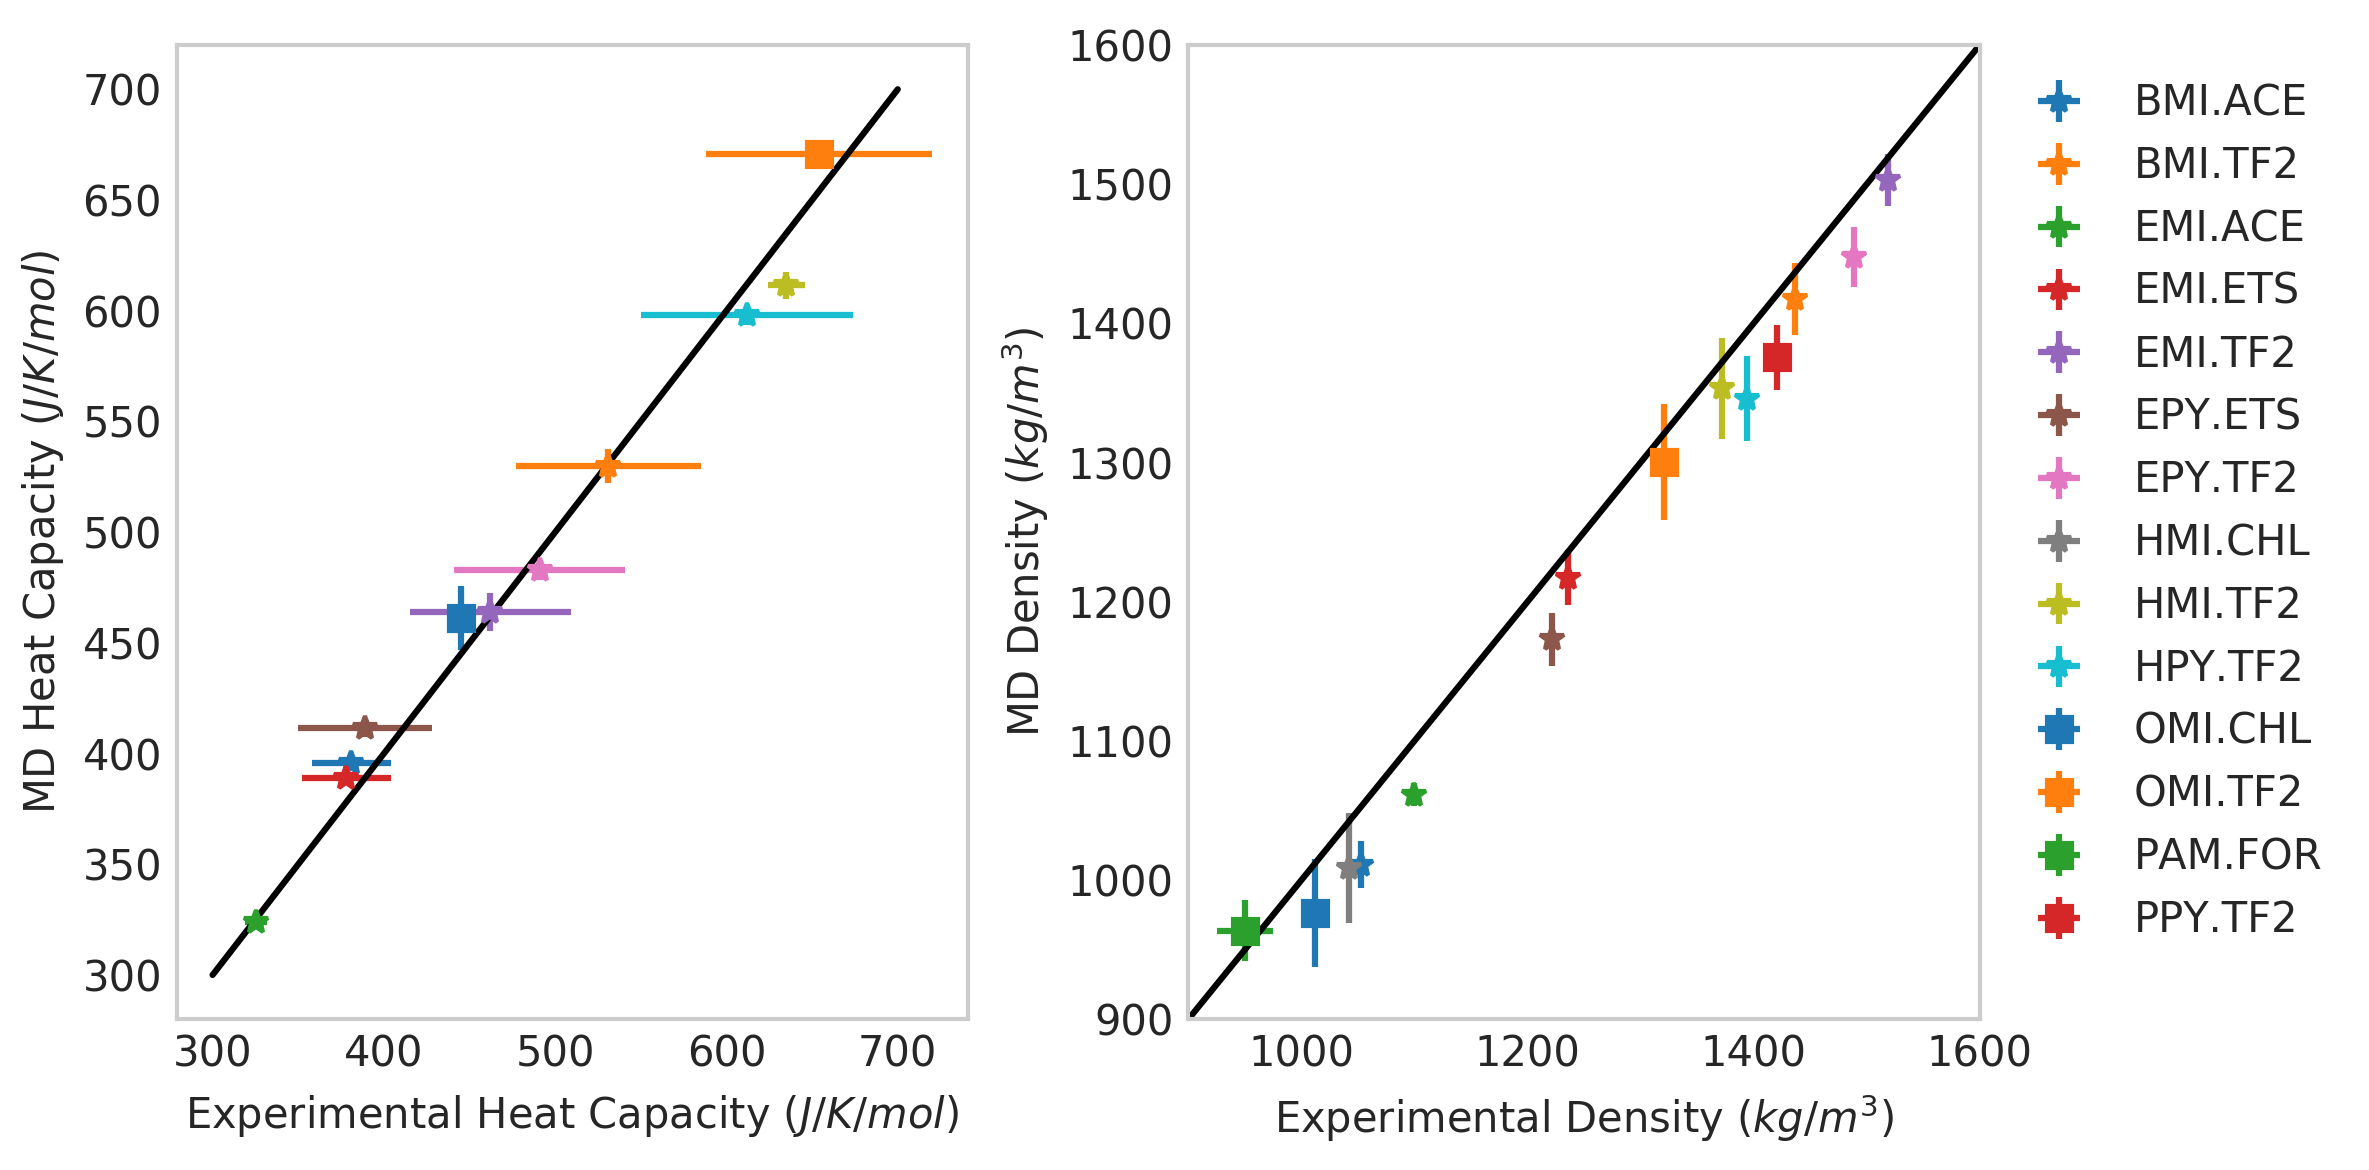

In [9]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(8,4), dpi=300)
    ax=fig.add_subplot(122)
    for i in range(1,df.shape[0]):
        marker='*'
        if i > 10:
            marker='s'
        scat = ax.errorbar(df["Exp_Density"][i],df["MD_Density"][i],xerr=df["Exp_Density_Std"][i],
                           yerr=df["MD_Density_Std"][i],
            marker=marker, linestyle=" ", label=df["Salt"][i])
    ax.plot([900,1700], [900,1700], linestyle="-", label=None, c="black")
    ax.grid()
    ax.set_ylabel("MD Density $(kg/m^3)$")
    ax.set_xlabel("Experimental Density $(kg/m^3)$")
    plt.xlim(900,1600,200)
    plt.ylim(900,1600,200)
    plt.legend(bbox_to_anchor=(1,1))
    ax = fig.add_subplot(121)
    for i in range(1,df.shape[0]):
        marker='*'
        if i > 10:
            marker='s'
        ax.errorbar(df["Exp_Cpt"][i],df["MD_Cpt"][i],xerr=df["Exp_Cpt_Std"][i],yerr=df["MD_Cpt_Std"][i],
            marker=marker, linestyle=" ")
    ax.plot([300,700], [300,700], linestyle="-", label=None, c="black")
    ax.grid()
    ax.set_ylabel("MD Heat Capacity $(J/K/mol)$")
    ax.set_xlabel("Experimental Heat Capacity $(J/K/mol)$")
    plt.tight_layout()

Compare the QSPR/NN models predictions to the experimental measurements:

In [10]:
model_ID = ['density', 'cpt']
parent_candidates, anion_candidates, models, deslists = load_salty_models(model_ID)

In [11]:
dens = []
cpt = []
print("density\t cp\t name_brev")
for key in smiles_dic:
    genes, anion = smiles_dic[key].split(".")
    anion = Chem.MolFromSmiles(anion)
    error, prediction = get_fitness(anion, genes, 1, models, deslists)
    print("{}\t {}\t {}".format(myround(prediction[0]), myround(prediction[1]), key))
    dens.append(prediction[0])
    cpt.append(prediction[1])

density	 cp	 name_brev
981.0	 273.0	 BAM.FOR
1050.0	 389.0	 BMI.ACE
1426.0	 548.0	 BMI.TF2
1100.0	 311.0	 EMI.ACE
1229.0	 395.0	 EMI.ETS
1504.0	 490.0	 EMI.TF2
1251.0	 370.0	 EPY.ETS
1533.0	 512.0	 EPY.TF2
1035.0	 367.0	 HMI.CHL
1365.0	 604.0	 HMI.TF2
1385.0	 610.0	 HPY.TF2
1012.0	 417.0	 OMI.CHL
1315.0	 659.0	 OMI.TF2
971.0	 267.0	 PAM.FOR
1414.0	 573.0	 PPY.TF2


In [12]:
df['NN_Density'] = dens
df['NN_Cpt'] = cpt

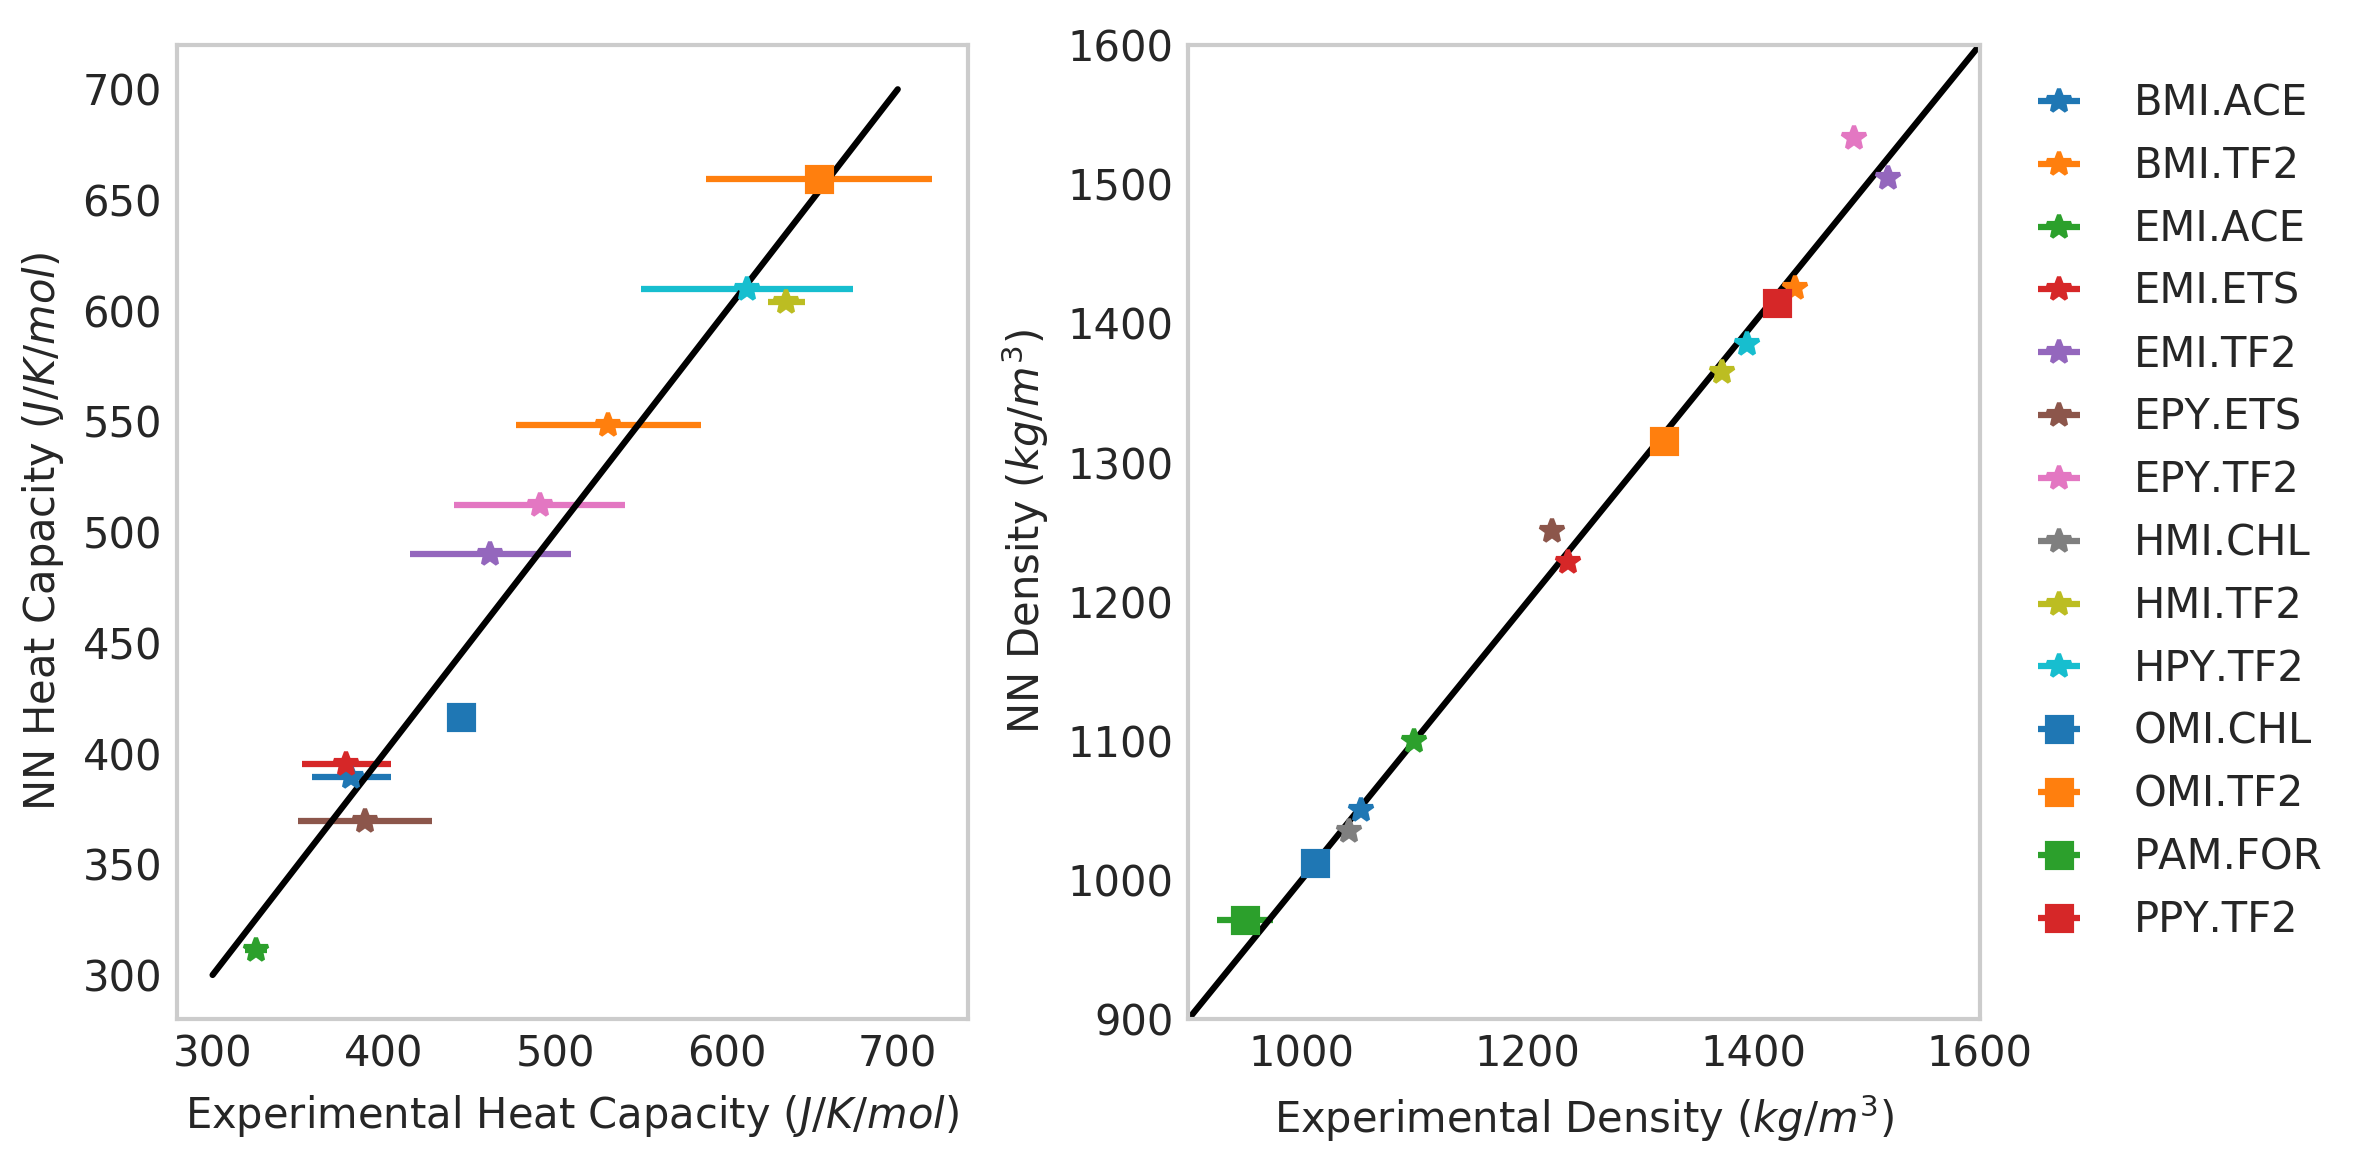

In [13]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(8,4), dpi=300)
    ax=fig.add_subplot(122)
    for i in range(1,df.shape[0]):
        marker='*'
        if i > 10:
            marker='s'
        scat = ax.errorbar(df["Exp_Density"][i],df["NN_Density"][i],xerr=df["Exp_Density_Std"][i],
                           yerr=None,
            marker=marker, linestyle=" ", label=df["Salt"][i])
    ax.plot([900,1700], [900,1700], linestyle="-", label=None, c="black")
    ax.grid()
    ax.set_ylabel("NN Density $(kg/m^3)$")
    ax.set_xlabel("Experimental Density $(kg/m^3)$")
    plt.xlim(900,1600,200)
    plt.ylim(900,1600,200)
    plt.legend(bbox_to_anchor=(1,1))
    ax = fig.add_subplot(121)
    for i in range(1,df.shape[0]):
        marker='*'
        if i > 10:
            marker='s'
        ax.errorbar(df["Exp_Cpt"][i],df["NN_Cpt"][i],xerr=df["Exp_Cpt_Std"][i],yerr=None,
            marker=marker, linestyle=" ", label=df['Salt'][i])
    ax.plot([300,700], [300,700], linestyle="-", label=None, c="black")
    ax.grid()
    ax.set_ylabel("NN Heat Capacity $(J/K/mol)$")
    ax.set_xlabel("Experimental Heat Capacity $(J/K/mol)$")    
    plt.tight_layout()

In [14]:
print("\t Density Cp")
print("Exp std: {:.1f}\t {:.1f}".format(np.average(np.abs((df["Exp_Density_Std"]) / df["Exp_Density"]))*100, 
                               np.sum(np.abs(df["Exp_Cpt_Std"]) / df["Exp_Cpt"])/df.shape[0]*100))
print("MD RAAD: {:.1f}\t {:.1f}".format(get_raad(df["MD_Density"], df["Exp_Density"]), 
                               get_raad(df.dropna()["MD_Cpt"], df.dropna()['Exp_Cpt'])))
print("NN RAAD: {:.1f}\t {:.1f}".format(get_raad(df["NN_Density"], df["Exp_Density"]), 
                               get_raad(df.dropna()["NN_Cpt"], df.dropna()['Exp_Cpt'])))

	 Density Cp
Exp std: 0.6	 5.2
MD RAAD: 2.9	 2.5
NN RAAD: 1.3	 3.8
